<a href="https://colab.research.google.com/github/Avichay3/Full-training/blob/main/Brain_tumor_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Mission Overview

A **Data science mission** involves building a system that learns from data to make predictions or discover patterns. The process begins by defining the problem, gathering and preparing the necessary data, choosing and training models, and finally deploying the model for real-world use. Each step ensures the model is optimized for accuracy, efficiency, and adaptability.

### Key Steps in an Data science Mission:
- **Define the problem**: Identify the goal (classification, regression, clustering, etc.).
- **Collect data**: Gather relevant data for the task.
- **Data preprocessing**: Clean, normalize, and prepare the data.
- **Exploratory Data Analysis (EDA)**: Explore patterns and relationships in the data.
- **Feature engineering**: Create or modify features to improve model performance.
- **Model selection**: Choose appropriate algorithms for the problem.
- **Model training**: Train the model using the training data.
- **Validation**: Validate model performance and tune hyperparameters.
- **Evaluation**: Test the model using appropriate metrics.
- **Deployment**: Deploy the model for real-world usage.

In this assignment we will get a good grip on the entire process of a Data science task. Here, you will experience the world of ML and DL.

Mission goal:
  * provide a full ML solution and analysis of *Bank Marketing Dataset*. https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset
  * provide a full DL solution and analysis of *MNIST Dataset*.
  https://www.kaggle.com/datasets/hojjatk/mnist-dataset

For each mission, be sure to fill the following cells. If you think anything is missing, please contact your instructor.

0. **Problem understanding**  
   - Understand what is the task that you are requested to solve. what is the buisness problem?
   - Be sure to understand your data. what are the features? what is the target?

Write the answer

1. **Data Loading**  
   - Load the provided dataset using appropriate libraries (e.g., `pandas`, `numpy`).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub
# download latest version
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")


Using Colab cache for faster access to the 'brain-tumor-classification-mri' dataset.


In [2]:

import os

print(path)
print(os.listdir(path))


/kaggle/input/brain-tumor-classification-mri
['Training', 'Testing']


In [3]:
import os

train_dir = os.path.join(path, "Training")
test_dir  = os.path.join(path, "Testing")

print("Train classes:", sorted(os.listdir(train_dir)))
print("Test classes:", sorted(os.listdir(test_dir)))


Train classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Test classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [4]:
import os

# check where is the files, if it is on my pc
print("running on kaggle:", os.path.exists("/kaggle"))



running on kaggle: True


I see that I run on the server of kaggle and not on my pc

In [5]:
# check what is the size of the images
from PIL import Image
import os

sample_class = os.listdir(train_dir)[0]
sample_img = os.listdir(os.path.join(train_dir, sample_class))[0]

img = Image.open(os.path.join(train_dir, sample_class, sample_img))
print(img.size)


(236, 236)


# Now I want to see some images and see the resolution and the input size images

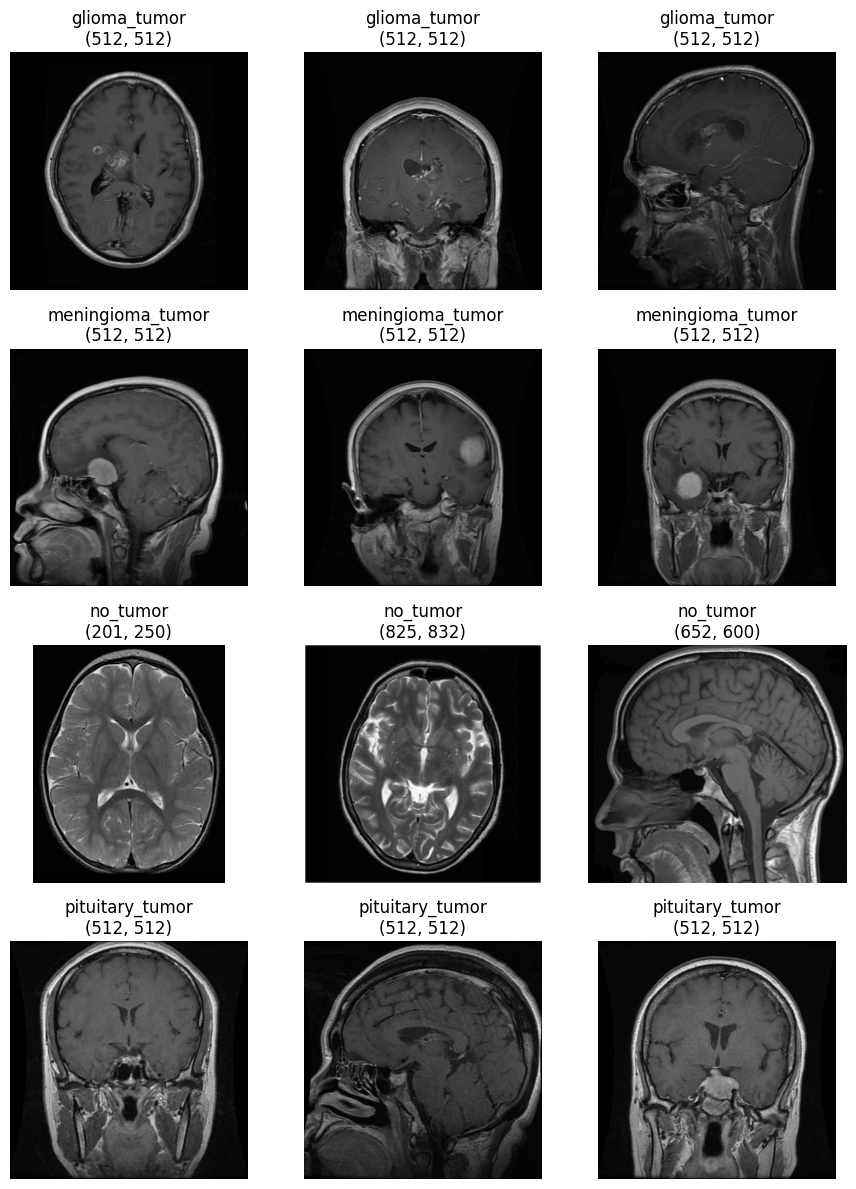

In [6]:
import random

class_names = sorted(os.listdir(train_dir))

SAMPLES_PER_CLASS = 3
random.seed(42)

plt.figure(figsize=(SAMPLES_PER_CLASS * 3, len(class_names) * 3))

plot_idx = 1


for cls in class_names:
    cls_dir = os.path.join(train_dir, cls)
    images = os.listdir(cls_dir)
    samples = random.sample(images, SAMPLES_PER_CLASS)

    for img_name in samples:
        img_path = os.path.join(cls_dir, img_name)
        img = Image.open(img_path)

        plt.subplot(len(class_names), SAMPLES_PER_CLASS, plot_idx)
        plt.imshow(img)
        plt.title(f"{cls}\n{img.size}")
        plt.axis("off")

        plot_idx += 1

plt.tight_layout()
plt.show()




lets change the images shape to be constant


In [7]:
import tensorflow as tf
import os

BASE_PATH = "/kaggle/input/brain-tumor-classification-mri"
TRAIN_DIR = os.path.join(BASE_PATH, "Training")

# change the size of the image to 224 * 224 because most of the pretrained models has an input size 224 *224 pixels
IMG_SIZE = (224, 224)
BATCH = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 2870 files belonging to 4 classes.
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


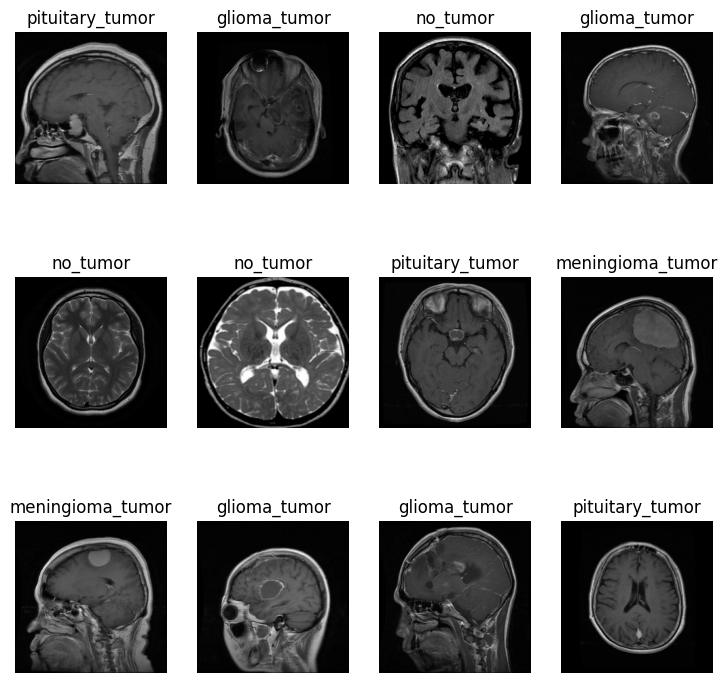

In [8]:
# plot some images to see the data
plt.figure(figsize=(9, 9))

for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

plt.show()


**Images were resized to 224×224 pixels without cropping, preserving the entire field of view**

2. **Exploratory Data Analysis (EDA)**  
   Perform an initial exploration of the data:
   - **Anomalies:** Identify any outliers or anomalies.
   - **Missing Values:** Check for missing values.
   - **Data Types:** Verify the types of your data (numerical, categorical, etc.).
   - **Class Imbalance (if applicable):** Check for imbalanced classes and address it if necessary (e.g., resampling techniques, class weighting).

   Awnser these questions and more to understand better the data:
   - What is the most common age group that survived?
   - Which pclass was more likely to survive?
   - How many children under the age of 18 died?
   - Ask your self some more questions, and show the answers using charts.

In [9]:
from PIL import Image

corrupted = 0
total = 0

for cls in os.listdir(train_dir):
    cls_dir = os.path.join(train_dir, cls)
    for img_name in os.listdir(cls_dir):
        total += 1
        try:
            img = Image.open(os.path.join(cls_dir, img_name))
            img.verify()
        except:
            corrupted += 1

print("total images:", total)
print("corrupted images:", corrupted)


total images: 2870
corrupted images: 0


now lets check class imbalance :

In [10]:
class_counts = {
    cls: len(os.listdir(os.path.join(train_dir, cls)))
    for cls in os.listdir(train_dir)
}

class_counts


{'no_tumor': 395,
 'pituitary_tumor': 827,
 'meningioma_tumor': 822,
 'glioma_tumor': 826}

we can see that there is some imbalance, because "no tumor" has 395 images while other classes has 822-827.
lets try to give class weight so that "no tumor" pay more for mistakes.
because there is approximatly two times from the other classes, every mistake will pay approximately two times more then the other classes.

**First I thaught to make an augmentation to the class with the imbalance, but it can make a problem with this data (medicine data). For example, we can't change the color of the images, resolution and so on..'
**

In [11]:
counts_in_order = np.array([class_counts[c] for c in class_names])
total = counts_in_order.sum()
num_classes = len(class_names)

class_weight = {
    i: total / (num_classes * counts_in_order[i])
    for i in range(num_classes)
}


for i, cls in enumerate(class_names):
    print(f"{cls}: count={counts_in_order[i]}, weight={class_weight[i]:.2f}")


glioma_tumor: count=826, weight=0.87
meningioma_tumor: count=822, weight=0.87
no_tumor: count=395, weight=1.82
pituitary_tumor: count=827, weight=0.87


**Now lets check anomalies in the data:**


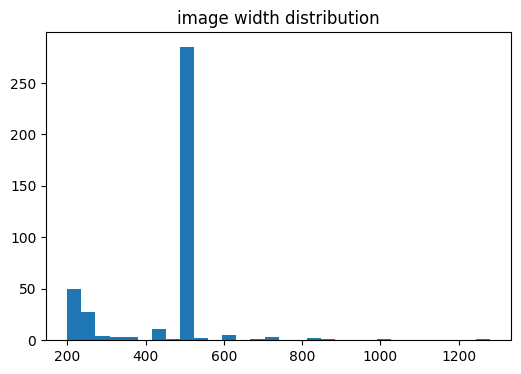

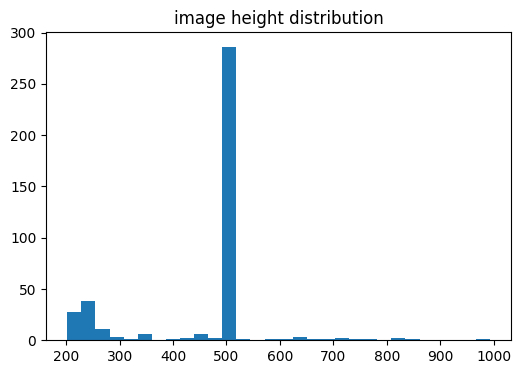

In [12]:
widths = []
heights = []

for cls in os.listdir(train_dir):
    cls_dir = os.path.join(train_dir, cls)
    for img_name in os.listdir(cls_dir)[:100]:
        img = Image.open(os.path.join(cls_dir, img_name))
        w, h = img.size
        widths.append(w)
        heights.append(h)

plt.figure(figsize=(6,4))
plt.hist(widths, bins=30)
plt.title("image width distribution")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(heights, bins=30)
plt.title("image height distribution")
plt.show()


In [13]:
print("avi")

avi


In [ ]:
''


3. **Data Cleaning**  
   - Handle missing values using appropriate techniques (imputation, deletion, etc.). Explain.
   - Deal with anomalies if necessary (e.g., transformation, capping, or removing outliers). Explain.

**data cleaning for the image dataset focused on file integrity and structural consistency. all the image files were verified and no missing or corrupted samples were found, eliminating the need for imputation or deletion. variability in
image resolution and appearance was identified as a form of structural anomaly rather than noise. these differences were addressed through resizing all images to a fixed resolution and applying standard normalization, ensuring consistency while preserving real-world variability.**

4. **Feature Engineering**  
   - Create new features or transform existing ones. Explain.
   - Handle categorical variables (e.g., one-hot encoding, label encoding). Explain.
   - Scale/normalize numerical data if necessary. Explain.
   - Remove redundant, irrelevant, or highly correlated features. Explain.
   - Use feature selection methods if applicable (e.g., recursive feature elimination, importance-based selection). Explain.

**feature engineering was primarily conducted implicitly through convolutional neural networks, which automatically learn hierarchical representations from raw image data. prior to training, images were resized to a fixed resolution to ensure consistent spatial representation, and pixel intensities were normalized using the preprocessing scheme of the pretrained network. the categorical target variable was encoded using integer labels. No manual feature selection or removal was performed, as the model learns task-relevant features end-to-end, while transfer learning served as an implicit feature selection mechanism by leveraging pretrained convolutional layers.**

5. **Data Splitting**  
   - Split the dataset into training, validation, and test sets: Explain how to split.
     - **Training set:** For model training.
     - **Validation set:** For hyperparameter tuning and validation.
     - **Test set:** For final model evaluation.
   - Consider using **cross-validation** for better validation if the dataset is small.

**the dataset was split into training, and test sets to ensure reliable evaluation. A predefined test set provided with the dataset was reserved exclusively for final performance assessment. the remaining data were used for training, with a validation subset extracted to support model selection and hyperparameter tuning. this approach prevents data leakage and enables unbiased evaluation. cross validation was not employed due to the computational cost of training deep convolutional networks and the sufficient size of the dataset.**

6. **Model Selection**  
   Train at least **3 different models** of your choice (e.g., Decision Trees, Random Forest, Logistic Regression, SVM, etc.):
   - Justify your model choices.
   - Evaluate your models using **3 metrics** (e.g., accuracy, precision, recall, F1 score, RMSE, etc.).
   - Explain model predictions using **interpretability** techniques (e.g., feature importance plots, SHAP).

In [16]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

print(class_names)


Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [17]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, ds, class_names, title=""):
    y_true = np.concatenate([y.numpy() for _, y in ds], axis=0)
    probs = model.predict(ds, verbose=0)
    y_pred = np.argmax(probs, axis=1)

    print("\n" + "="*70)
    print(title)
    print("="*70)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


In [18]:
import tensorflow as tf

def build_simple_cnn(input_shape=(224,224,3), num_classes=4):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)

    x = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

cnn = build_simple_cnn((IMG_SIZE[0], IMG_SIZE[1], 3), num_classes)
hist_cnn = cnn.fit(train_ds, validation_data=val_ds, epochs=8, class_weight=class_weight)
evaluate_model(cnn, test_ds, class_names, "Model 1: Simple CNN (from scratch)")


Epoch 1/8
51/72 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.2107 - loss: 1.3869

KeyboardInterrupt: 

7. **Model Optimization**  
   - Perform hyperparameter tuning using techniques like **GridSearchCV** or **RandomizedSearchCV**.
   - Apply feature selection if necessary.

8. **Evaluation and Comparison**  
   - Use training, validation, and test sets to evaluate and compare your models.
   - For each metric, explain why you chose it.
   - Create plots to visualize:
     - The performance of each model on validation and test sets.
     - The impact of hyperparameters on model performance.
   - Use visual aids (e.g., confusion matrices, ROC curves, precision-recall curves) to show results.

9. **Model Interpretability**  
   - Use techniques like **SHAP** or **LIME** to explain how models make predictions.
   - Visualize which features are most influential in your model’s decisions.

10. **Summary and Recommendations**  
   - Summarize your findings:
     - Which model performed best?
     - What hyperparameters were most influential?
     - What feature engineering/selection techniques were effective?
   - Address potential **concept drift** or how the model could be maintained over time.

11. **Presentation** (ask your instructor if you should do it)
   - Prepare a presentation of your results, including important findings, experiments, and visualizations.
   - Be prepared to explain your decisions and reasoning behind each choice.